In [1]:
# Module imports

import numpy as np
import matplotlib.pyplot as plt
from LRFutils import archive, progress
from src import plot
from scipy.special import wofz
from multiprocess import Pool, cpu_count
import os
import pyvtk as vtk

try:
    ncpu = cpu_count()
except:
    with open(os.getenv("OAR_NODEFILE"), 'r') as f:
        ncpu = len(f.readlines())

pool = Pool(ncpu)

---

# Config

In [2]:
# Config

N = 256 # resolution in pixel
space_range = [-1, 1] # space interval (arbitrary unit)

nb_images = 10 # number of generated image
# ⚠️ Be carefull, the final dataset will be proportional to 6 * nb_images * N^2

---

# Definitions

In [3]:
# Function definition 

def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def lorentzian(x, mu, gamma):
    return gamma / (np.pi * ((x - mu)**2 + gamma**2))

def plummer(r, a):
    return 3/(4*np.pi*a**3)*(1 + r**2 / a**2)**(-5/2)

def voigt_profile(freq_range, sigma, gamma):
    """
    Calcule le profil de Voigt centré sur zéro pour une plage de fréquence donnée,
    avec une valeur de sigma et une valeur de gamma données.
    """
    x = freq_range
    y = np.zeros_like(x)
    for i, x_i in enumerate(x):
        z = (x_i + 1j * gamma) / (sigma * np.sqrt(2))
        y[i] = np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))
    return y


In [4]:
# Initializations

r, dr = np.linspace(space_range[0], space_range[1], N, endpoint=True, retstep=True)
X, Y, Z = np.meshgrid(r, r, r)

---

# Density generation

## Lorentzian

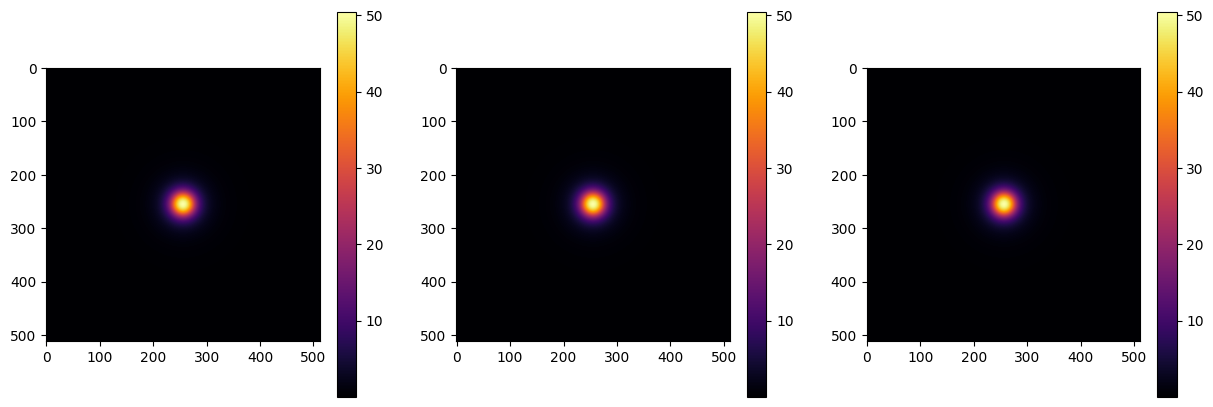

In [5]:
# Generating lorentzian in a bigger space

def lorentzian_3D():
    tmp_r, tmp_dr = np.linspace(space_range[0]*2, space_range[1]*2, N*2, endpoint=True, retstep=True)
    tmp_X, tmp_Y, tmp_Z = np.meshgrid(tmp_r, tmp_r, tmp_r)

    return 1/(1+(tmp_X**2+tmp_Y**2+tmp_Z**2)**2*1000)

cloud = lorentzian_3D()
plot.sum_in_3_directions(cloud)

## Noise

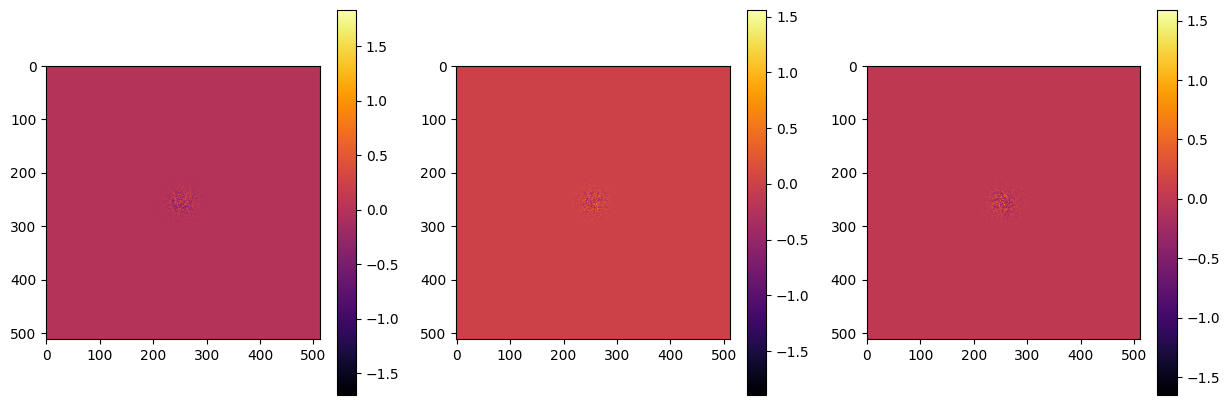

In [6]:
# Adding noise

def noise(cloud):
    return cloud * np.random.normal(0, 0.1, size=(N*2, N*2, N*2))

cloud = noise(cloud)
plot.sum_in_3_directions(cloud)

## Fourier transform

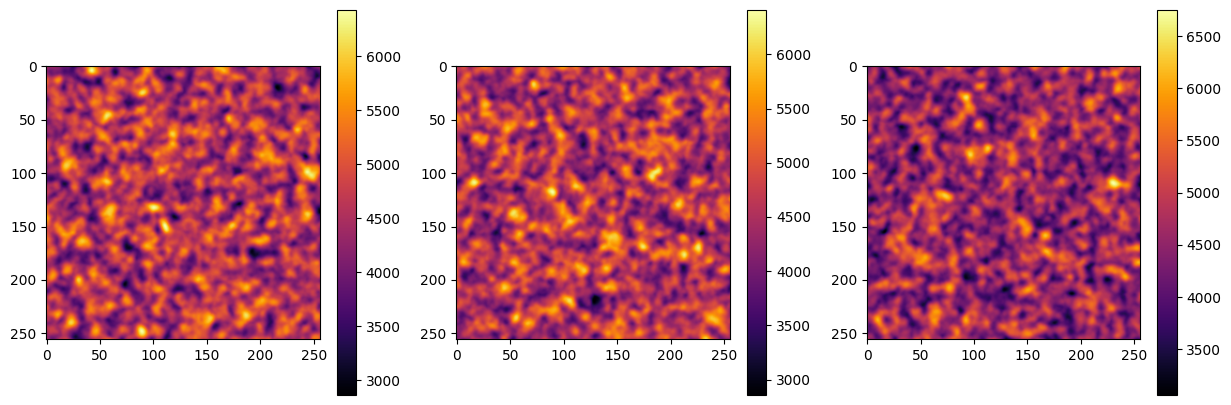

In [7]:
# Computing the fourier transform and cropping to a smaller space
# in order to avoid symmetries induced by the lorentzian shape

def fft(cloud):
    return np.abs(np.fft.fftn(cloud))

def crop(cloud):
    return cloud[:N, :N, :N]

cloud = fft(cloud)
cloud = crop(cloud)

plot.sum_in_3_directions(cloud)

## Plummer profile

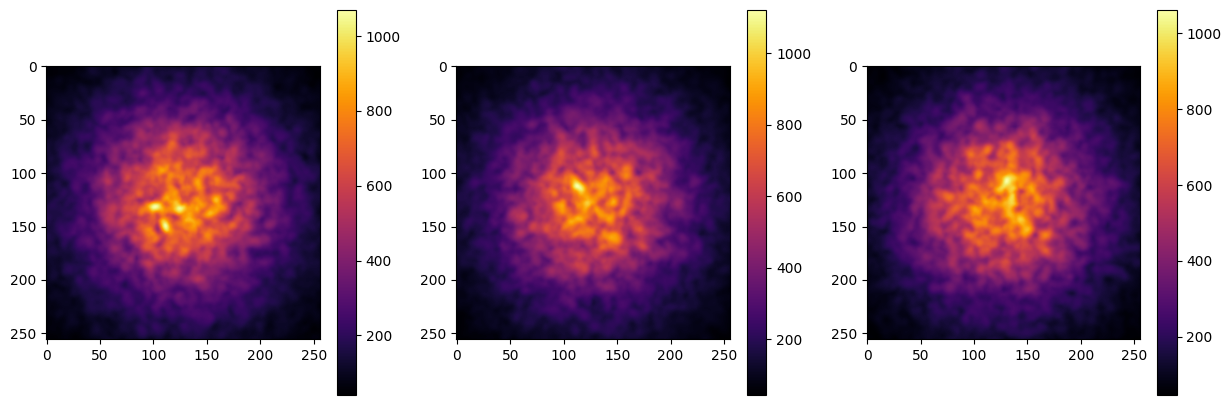

In [8]:
def plummerize(cloud):
    return cloud * plummer(np.sqrt(X**2+Y**2+Z**2), 0.9)

def normalize(cloud):
    return cloud / np.amax(cloud)

cloud = plummerize(cloud)

plot.sum_in_3_directions(cloud)

## Adding an additional Gaussian profile to create artificially a global maximum

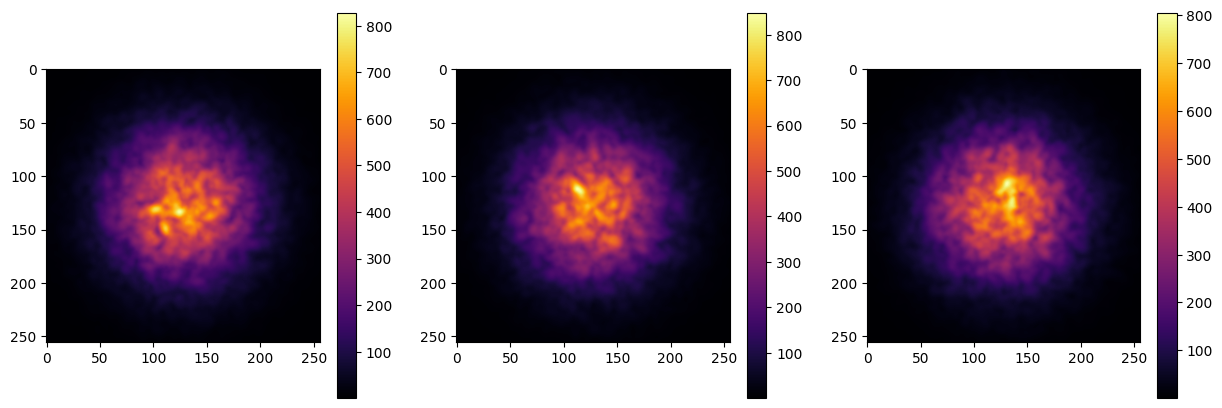

In [9]:
def guassianize(cloud):
    g = gaussian(np.sqrt(X**2+Y**2+Z**2), 0, 0.5)
    return cloud * g

cloud = guassianize(cloud)
plot.sum_in_3_directions(cloud)

## Normalize the density (max = 1)

In [10]:

cloud = normalize(cloud)

## Saving to a vtk file to view it with ParaView

In [11]:
def savevtk(cloud, N, name):
    """
    Function that save the density cube in a .vtk file

    Arguments:
    ----------
        cloud: numpy array
            Density cube

        N: int
            The resolution of the output cube(s)

        name: str
            prefix of the file
    """

    pointdata = vtk.PointData((vtk.Scalars(cloud.reshape(N**3,), name='Scalars0')))
    data = vtk.VtkData(vtk.StructuredPoints([N, N, N]), pointdata)
    data.tofile('{}'.format(name), 'binary')

savevtk(cloud, N, 'cloud')

---

# Velocity generation

## Density gradient

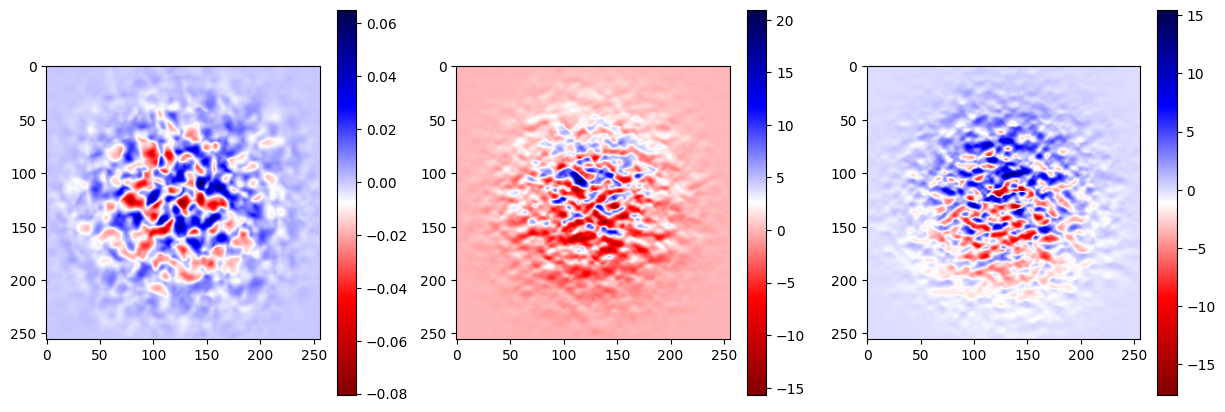

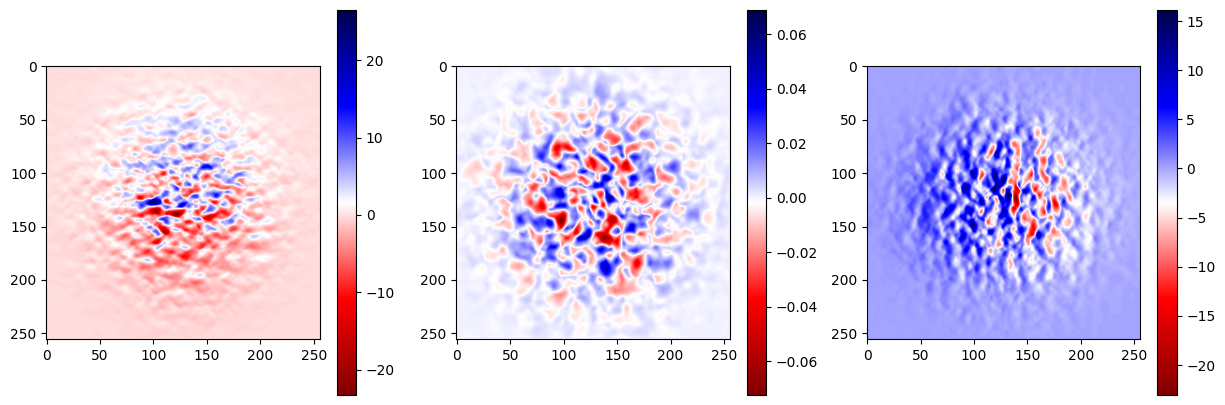

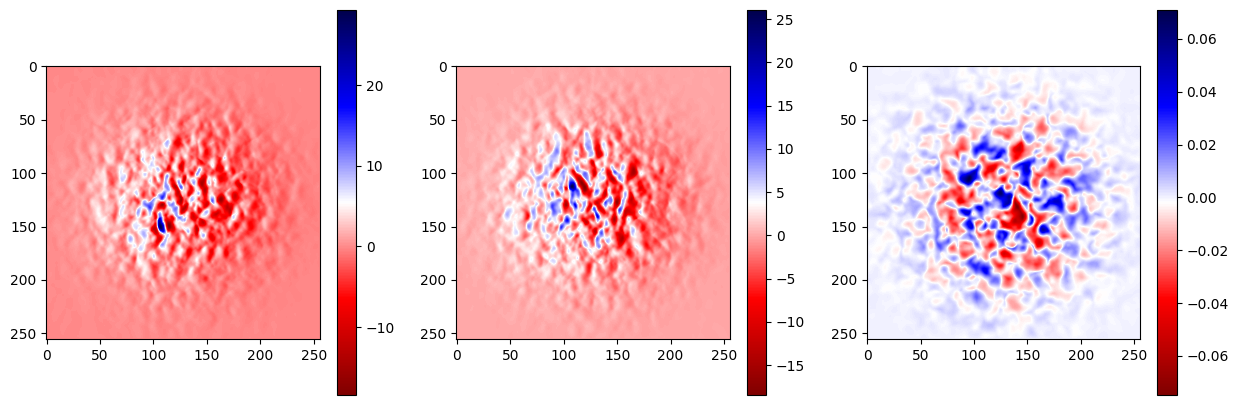

In [12]:
def velocity_grad(cloud):
    cloud_gradient = np.gradient(cloud, dr)

    vx_grad = cloud_gradient[0] / np.amax(np.abs(cloud_gradient[0]))
    vy_grad = cloud_gradient[1] / np.amax(np.abs(cloud_gradient[1]))
    vz_grad = cloud_gradient[2] / np.amax(np.abs(cloud_gradient[2]))

    # Removing aberrant values at the edges
    for v in [vx_grad, vy_grad, vz_grad]:
        v[0,:,:] = 0
        v[-1,:,:] = 0
        v[:,0,:] = 0
        v[:,-1,:] = 0
        v[:,:,0] = 0
        v[:,:,-1] = 0

    return vx_grad, vy_grad, vz_grad

vx_grad, vy_grad, vz_grad = velocity_grad(cloud)

plot.sum_in_3_directions(vx_grad, "seismic_r")
plot.sum_in_3_directions(vy_grad, "seismic_r")
plot.sum_in_3_directions(vz_grad, "seismic_r")

## Rotational speed

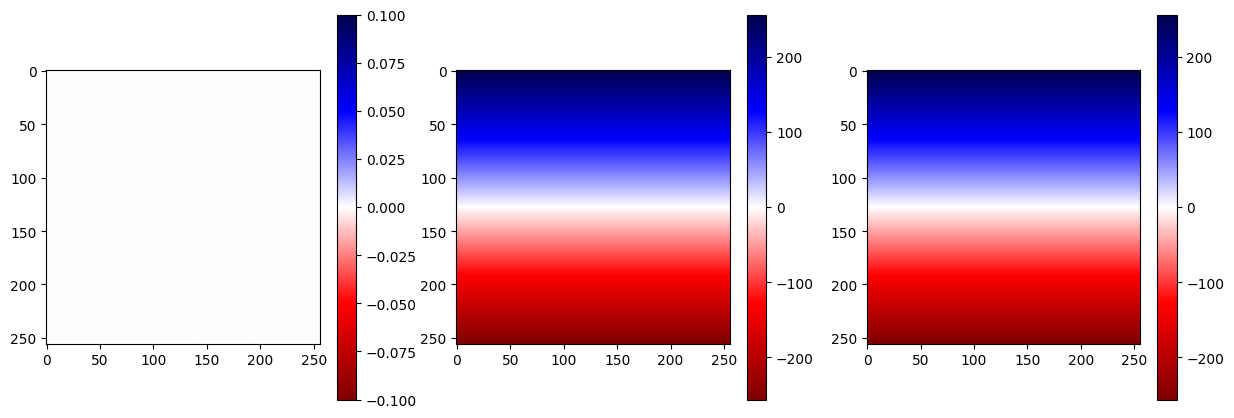

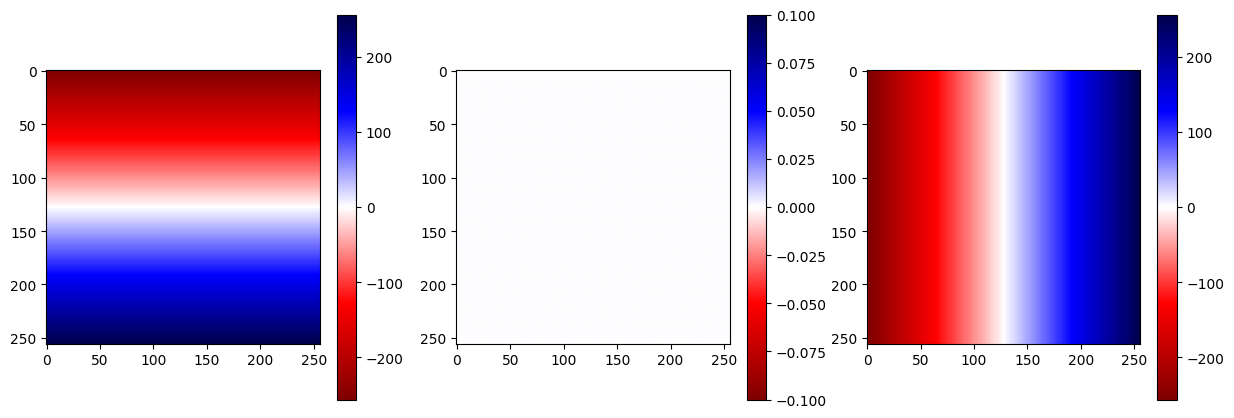

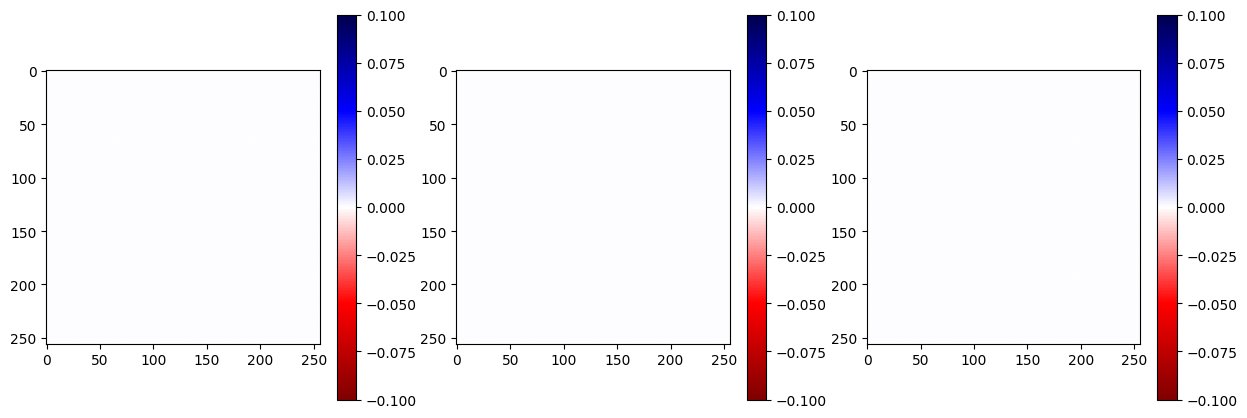

In [13]:
def velocity_rot():
    vx_rot = -Y / np.amax(np.abs(Y))
    vy_rot = X  / np.amax(np.abs(X))
    vz_rot = X * 0

    return vx_rot, vy_rot, vz_rot

vx_rot, vy_rot, vz_rot = velocity_rot()

plot.sum_in_3_directions(vx_rot, "seismic_r")
plot.sum_in_3_directions(vy_rot, "seismic_r")
plot.sum_in_3_directions(vz_rot, "seismic_r")

## Speed average

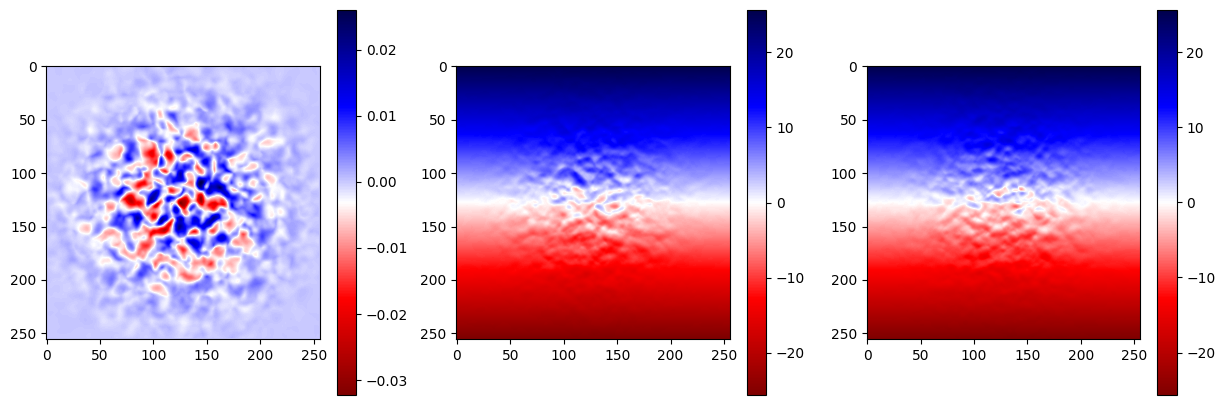

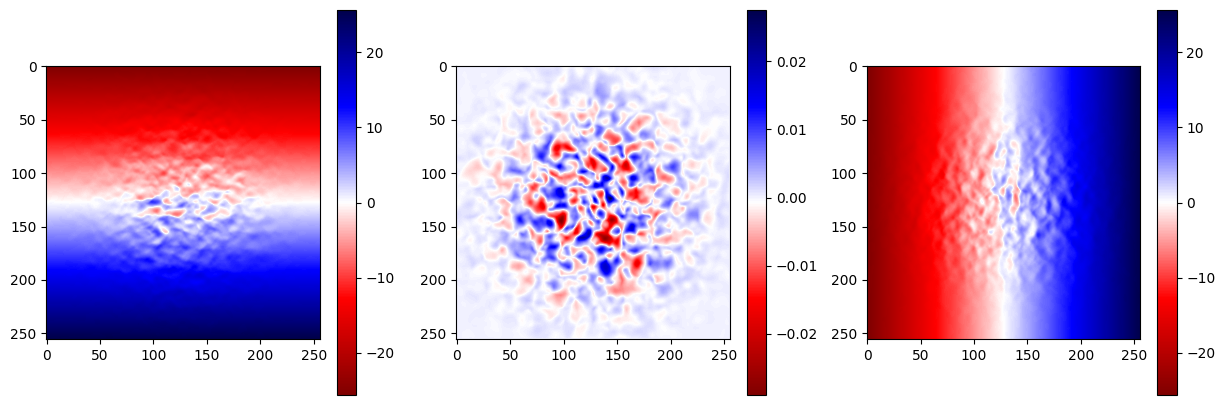

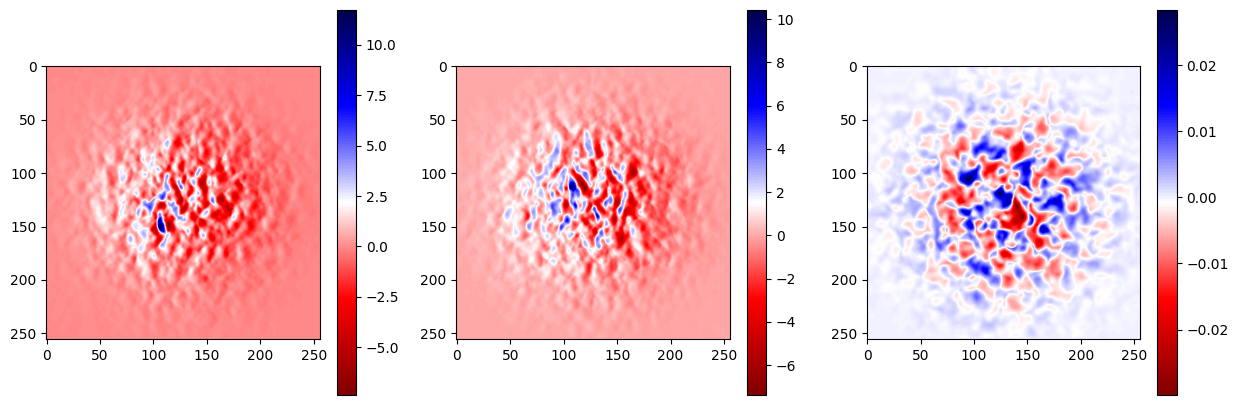

In [14]:
def velocity_average(vx_grad, vy_grad, vz_grad, vx_rot, vy_rot, vz_rot):
    rot_prop = 0.2
    vx = ((1-rot_prop) * vx_grad + rot_prop * vx_rot)/2
    vy = ((1-rot_prop) * vy_grad + rot_prop * vy_rot)/2
    vz = ((1-rot_prop) * vz_grad + rot_prop * vz_rot)/2

    return vx, vy, vz

vx, vy, vz = velocity_average(vx_grad, vy_grad, vz_grad, vx_rot, vy_rot, vz_rot)

plot.sum_in_3_directions(vx, "seismic_r")
plot.sum_in_3_directions(vy, "seismic_r")
plot.sum_in_3_directions(vz, "seismic_r")

---

# Spectrum generation

## Voigt profile

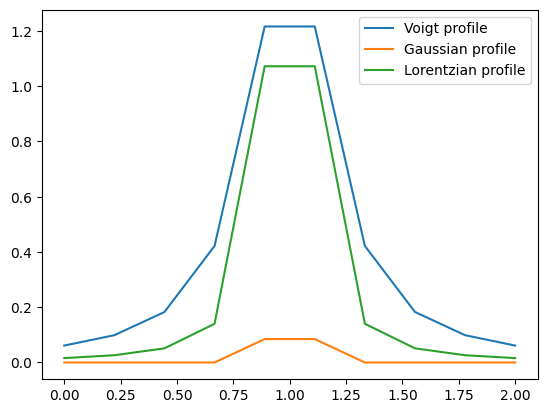

In [15]:
m = 1
s = 0.05
sl = 0.05

sigma = 0.01
gamma = 0.2

# frequency range
f = np.linspace(0, 2, 10)

plt.plot(f, voigt_profile(f-1, sigma, gamma), label="Voigt profile")
plt.plot(f, gaussian(f, m, s), label="Gaussian profile")
plt.plot(f, lorentzian(f, m, sl), label="Lorentzian profile")
plt.legend()
plt.show()

## Rotation of data according to the observation axis

In [16]:
def rotate_data(cloud, v):

    cloud_obs = []
    vx_obs = []
    vy_obs = []
    vz_obs = []

    vx, vy, vz = v

    for i in range(6):
        cloud_obs.append(np.zeros((N, N, N)))
        vx_obs.append(np.zeros((N, N, N)))
        vy_obs.append(np.zeros((N, N, N)))
        vz_obs.append(np.zeros((N, N, N)))

    for x in range(N):
        for y in range(N):
            for z in range(N):

                cloud_obs[0][x,y,z] = cloud[z,x,y]
                cloud_obs[1][x,y,z] = cloud[x,-(z+1),y]
                cloud_obs[2][x,y,z] = cloud[x,y,z]

                cloud_obs[3][x,y,z] = cloud[-(z+1),-(x+1),y]
                cloud_obs[4][x,y,z] = cloud[-(x+1),z,y]
                cloud_obs[5][x,y,z] = cloud[-(x+1),y,-(z+1)]

                vx_obs[0][x,y,z] = vy[z,x,y]
                vy_obs[0][x,y,z] = vz[z,x,y]
                vz_obs[0][x,y,z] = vx[z,x,y]

                vx_obs[1][x,y,z] = vx[x,-(z+1),y]
                vy_obs[1][x,y,z] = vz[x,-(z+1),y]
                vz_obs[1][x,y,z] = vy[x,-(z+1),y]

                vx_obs[2][x,y,z] = vx[x,y,z]
                vy_obs[2][x,y,z] = vy[x,y,z]
                vz_obs[2][x,y,z] = vz[x,y,z]

                vx_obs[3][x,y,z] = vy[-(z+1),-(x+1),y]
                vy_obs[3][x,y,z] = vz[-(z+1),-(x+1),y]
                vz_obs[3][x,y,z] = vx[-(z+1),-(x+1),y]

                vx_obs[4][x,y,z] = vx[-(x+1),z,y]
                vy_obs[4][x,y,z] = vz[-(x+1),z,y]
                vz_obs[4][x,y,z] = vy[-(x+1),z,y]

                vx_obs[5][x,y,z] = vx[-(x+1),y,-(z+1)]
                vy_obs[5][x,y,z] = vy[-(x+1),y,-(z+1)]
                vz_obs[5][x,y,z] = vz[-(x+1),y,-(z+1)]

    return cloud_obs, vx_obs, vy_obs, vz_obs

cloud_obs, vx_obs, vy_obs, vz_obs = rotate_data(cloud, (vx, vy, vz))

In [ ]:
def compute_spectrum_hypercube(cloud, vz):  

    spectrum_hypercube = np.zeros((N, N, N, len(f)))

    bar = progress.Bar(N**2, prefix="Generating spectra")
    for x in range(N):
        for y in range(N):
            bar(x*N + y)
            for z in range(N):
                spectrum_hypercube[x,y,z,:] = lorentzian(f+3*vz[x,y,z], m, sl) * cloud[x,y,z]
                # spectrum_hypercube[x,y,z,:] = gaussian(f+3*vz[x,y,z], m, s) * cloud[x,y,z]
                # spectrum_hypercube[x,y,z,:] = voigt_profile(f+3*vz[x,y,z], sigma, gamma) * cloud[x,y,z]
    
    bar(N**2)
    return spectrum_hypercube

def observe(spectrum_hypercube):
    return np.sum(spectrum_hypercube, axis=2) # Sum over Z axis

# observations = []
# def observations_callback(observation):
#     observations.append(observation)

def generate_observations(cloud_obs, vz_obs, verbose=False):
    spectrum_hypercubes = []
    observations = []
    for i in range(6):
        print(f"Observation {i+1}/6")
        spectrum_hypercubes.append(compute_spectrum_hypercube(cloud_obs[i], vz_obs[i]))
        observations.append(observe(spectrum_hypercubes[-1]))
    
    return spectrum_hypercubes, observations

spectrum_hypercubes, observations = generate_observations(cloud_obs, vz_obs, verbose=True)

Observation 1/6
Generating spectra ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 65536/65536 0:02:21ta 0:00:00
Observation 2/6
Generating spectra ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 65536/65536 0:02:24ta 0:00:00
Observation 3/6
Generating spectra ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 65536/65536 0:02:27ta 0:00:00
Observation 4/6
Generating spectra ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 65536/65536 0:02:25ta 0:00:00
Observation 5/6


# Observation from X+ axis

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

# # Taking the mean of windows of N//10 pixels
# repr_x = np.zeros((10, 10, 100))
# for i in range(10):
#     for j in range(10):
#         repr_x[i,j,:] = np.mean(spectrum_hypercube_x[i*N//10:(i+1)*N//10, j*N//10:(j+1)*N//10, :], axis=(0,1))

# Taking one pixel every 10
repr_x = observations[0][::N//10,::N//10, :]

for i in range(10):
    for j in range(10):
        axs[i,j].plot(f, repr_x[i,j,:])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im = axs[0].imshow(observations[0][:,:,25], cmap="inferno")
fig.colorbar(im)
im = axs[1].imshow(observations[0][:,:,50], cmap="inferno")
fig.colorbar(im)
im = axs[2].imshow(observations[0][:,:,75], cmap="inferno")
fig.colorbar(im)
plt.save("X.png")
plt.show()

# Observation from Y+ axis

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

# # Taking the mean of windows of N//10 pixels
# repr_y = np.zeros((10, 10, 100))
# for i in range(10):
#     for j in range(10):
#         repr_y[i,j,:] = np.mean(spectrum_hypercube_y[i*N//10:(i+1)*N//10, j*N//10:(j+1)*N//10, :], axis=(0,1))

# Taking one pixel every 10
repr_y = observations[1][::N//10,::N//10, :]

for i in range(10):
    for j in range(10):
        axs[i,j].plot(f, repr_y[i,j,:])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im = axs[0].imshow(observations[1][:,:,25], cmap="inferno")
fig.colorbar(im)
im = axs[1].imshow(observations[1][:,:,50], cmap="inferno")
fig.colorbar(im)
im = axs[2].imshow(observations[1][:,:,75], cmap="inferno")
fig.colorbar(im)
plt.save("Y.png")
plt.show()

# Observation from Z+ axis

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

# # Taking the mean of windows of N//10 pixels
# repr_z = np.zeros((10, 10, 100))
# for i in range(10):
#     for j in range(10):
#         repr_z[i,j,:] = np.mean(spectrum_hypercube_z[i*N//10:(i+1)*N//10, j*N//10:(j+1)*N//10, :], axis=(0,1))

# Taking one pixel every 10
repr_z = observations[2][::N//10,::N//10, :]

for i in range(10):
    for j in range(10):
        axs[i,j].plot(f, repr_z[i,j,:])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im = axs[0].imshow(observations[2][:,:,25], cmap="inferno")
fig.colorbar(im)
im = axs[1].imshow(observations[2][:,:,50], cmap="inferno")
fig.colorbar(im)
im = axs[2].imshow(observations[2][:,:,75], cmap="inferno")
fig.colorbar(im)
plt.save("Z.png")
plt.show()

---

# Generating dataset

In [ ]:
def save(i, cloud_obs, vx_obs, vy_obs, vz_obs, observations):
    for j in range(6):
        np.savez_compressed(
            f"dataset/cloud_{i}_obs_{j}.npz",
            cloud=cloud_obs[j],
            vx=vx_obs[j],
            vy=vy_obs[j],
            vz=vz_obs[j],
            observation=observations[j]
        )

save(0, cloud_obs, vx_obs, vy_obs, vz_obs, observations)

def generate_set(i):

    print(f"Generating cloud {i+2}/{nb_images}...")

    # Generate the cloud
    cloud = lorentzian_3D()
    cloud = noise(cloud)
    cloud = fft(cloud)
    cloud = crop(cloud)
    cloud = plummerize(cloud)
    cloud = guassianize(cloud)
    cloud = normalize(cloud)

    # Compute the velocity
    v_grad = velocity_grad(cloud)
    v_rot = velocity_rot()
    v = velocity_average(*v_grad, *v_rot)

    # Rotate the data
    cloud_obs, vx_obs, vy_obs, vz_obs = rotate_data(cloud, v)

    # Compute observations
    spectrum_hypercubes, observations = generate_observations(cloud_obs, vz_obs, verbose=False)

    print(i+1)
    save(i+1, cloud_obs, vx_obs, vy_obs, vz_obs, observations)

    return i+1

#bar = progress.Bar(nb_images-1)
#for i in  range(nb_images-1):
#    print("test", i+1)
#    pool.apply_async(func=generate_set, args=(i,), callback=bar)